https://www.kaggle.com/c/womens-machine-learning-competition-2018

# Info

**What to predict:**

* Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA® tournaments (2014-2017).
* Stage 2 - You should submit predicted probabilities for every possible matchup before the 2018 tournament begins.

* During any given season, day number zero is defined to be exactly 19 weeks earlier than Selection Monday, so Day #0 is a Monday in late October or early November such that Day #132 is Selection Sunday (for the men's tournament) and Day #133 is Selection Monday (for the women's tournament).

* This doesn't necessarily mean that the regular season will always start exactly on Day #0; in fact, during the past decade, regular season games typically start being played on a Friday that is either Day #4 or Day #11, but further back there was more variety.

* There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID).

2017 season and 2018 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = days 144/145 (Sweet Sixteen, Fri/Sat)
    Round 4 = days 146/147 (Elite Eight, Sun/Mon)
    National Seminfinal = day 151 (Fri)
    National Final = day 153 (Sun)

2015 season and 2016 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = days 144/145 (Sweet Sixteen, Fri/Sat)
    Round 4 = days 146/147 (Elite Eight, Sun/Mon)
    National Seminfinal = day 153 (Sun)
    National Final = day 155 (Tue)

2003 season through 2014 season:

    Round 1 = days 138/139 (Sat/Sun)
    Round 2 = days 140/141 (Mon/Tue)
    Round 3 = days 145/146 (Sweet Sixteen, Sat/Sun)
    Round 4 = days 147/148 (Elite Eight, Mon/Tue)
    National Seminfinal = day 153 (Sun)
    National Final = day 155 (Tue)

1998 season through 2002 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = day 145 only (Sweet Sixteen, Sat)
    Round 4 = day 147 only (Elite Eight, Mon)
    National Seminfinal = day 151 (Fri)
    National Final = day 153 (Sun)


# Import / Utils

In [1]:
import os, math, re, datetime, sklearn, warnings, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import forest
from sklearn.metrics import r2_score
from multiprocessing import cpu_count
%matplotlib inline

pd.set_option('display.max_columns', None)
n_cpu = cpu_count()
n_cpu

12

In [2]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def df_splits(df, val=0.15, test=None):
    if test is None: test = 0.0
    n = len(df)
    idxs = np.random.permutation(n)
    n_val, n_test = int(n*val), int(n*test)
    val_idxs = idxs[:n_val]
    test_idxs = idxs[n_val:n_val+n_test]
    train_idxs = idxs[n_val+n_test:]
    
    return df.iloc[train_idxs], df.iloc[val_idxs], df.iloc[test_idxs]

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement."""
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def train_cats(df):
    '''Change any columns of strings in a panda's dataframe to a column of
    catagorical values. This applies the changes inplace.'''
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    '''Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.'''
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def fix_missing(df, col, name, na_dict):
    '''Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.'''
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    ''' Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.'''
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> x, y, nas = proc_df(df, 'col1')
    >>> x

       col2
    0     1
    1     2
    2     1

    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])

    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])

    >>>round(fit_transform!(mapper, copy(data)), 2)

    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res


# Load files

In [3]:
df_data = pd.read_feather('data/df_data')

In [4]:
df_data.Season.unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

## Preprocess to model

In [5]:
seasons_validation = [2014, 2015, 2016, 2017] # Same seasons asked for stage 1

In [6]:
mask = df_data.Season.isin(seasons_validation)
df_train = df_data
df_val = df_data[df_data.Season.isin(seasons_validation) & df_data.NCAA]
df_train.shape, df_val.shape

((195890, 172), (504, 172))

In [7]:
x_train, y_train, nas = proc_df(df_train, 'Pred')
x_val, y_val, _ = proc_df(df_val, 'Pred', na_dict=nas)
# nas

# Random forest

## Functions

In [29]:
def get_pred(m, x):
    y_ = m.predict(x)
    return y_.clip(1e-9,1-1e-9)

def crit(y, y_):
    crit = ( y*np.log(y_) ) + ( (1 - y)*np.log(1 - y_) )
    return -crit.mean()

def rf_score(season, subset=True):
    m = models[season]
    yh_train = get_pred(m, x_train)
    print(f'Train score     : crit={crit(y_train, yh_train):0.4f}, r2={r2_score(y_train, yh_train):0.4f}')
    if x_val.shape[0] > 0:
        mask_val = x_val.Season == season if subset else np.ones(x_val.shape[0], bool)
        yh_val = get_pred(m, x_val[mask_val])
        print(f'Validation score: crit={crit(y_val[mask_val], yh_val):0.4f}, r2={r2_score(y_val[mask_val], yh_val):0.4f}')
    if m.oob_score:
        print(f'Oob score       : {" "*13}r2={m.oob_score_:0.4f}')


## Model

In [9]:
# 1 model per season to predict
params = dict(n_estimators=100, min_samples_split=25, min_samples_leaf=10,
              max_features=150, oob_score=True, n_jobs=n_cpu)
models = {s:RandomForestRegressor(**params) for s in seasons_validation}

In [22]:
for season in models:
    print(f'Model {season}:')
    mask = (x_train.Season < season) | ( (x_train.Season == season) & (~x_train.NCAA) )
    models[season].fit(x_train[mask], y_train[mask])
    rf_score(season)
    print('-'*40)

Model 2014:
Train score     : crit=0.4426, r2=0.4235
Validation score: crit=0.4450, r2=0.4058
Oob score       :              r2=0.2705
----------------------------------------
Model 2015:
Train score     : crit=0.4327, r2=0.4396
Validation score: crit=0.3750, r2=0.5142
Oob score       :              r2=0.2706
----------------------------------------
Model 2016:
Train score     : crit=0.4260, r2=0.4503
Validation score: crit=0.4938, r2=0.2969
Oob score       :              r2=0.2716
----------------------------------------
Model 2017:
Train score     : crit=0.4195, r2=0.4605
Validation score: crit=0.4584, r2=0.4004
Oob score       :              r2=0.2724
----------------------------------------


Public leaderboard: 0.663292

In [11]:
with open('data/02_models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [13]:
!ls -lh data

total 580M
-rw-rw-r-- 1 rhermoza rhermoza 315M Feb 26 00:53 02_models.pkl
-rw-r--r-- 1 rhermoza rhermoza 255M Feb 26 00:23 df_data
-rw-r--r-- 1 rhermoza rhermoza  11M Feb 26 00:35 df_submission


# Exploring

In [31]:
m = models[2017]

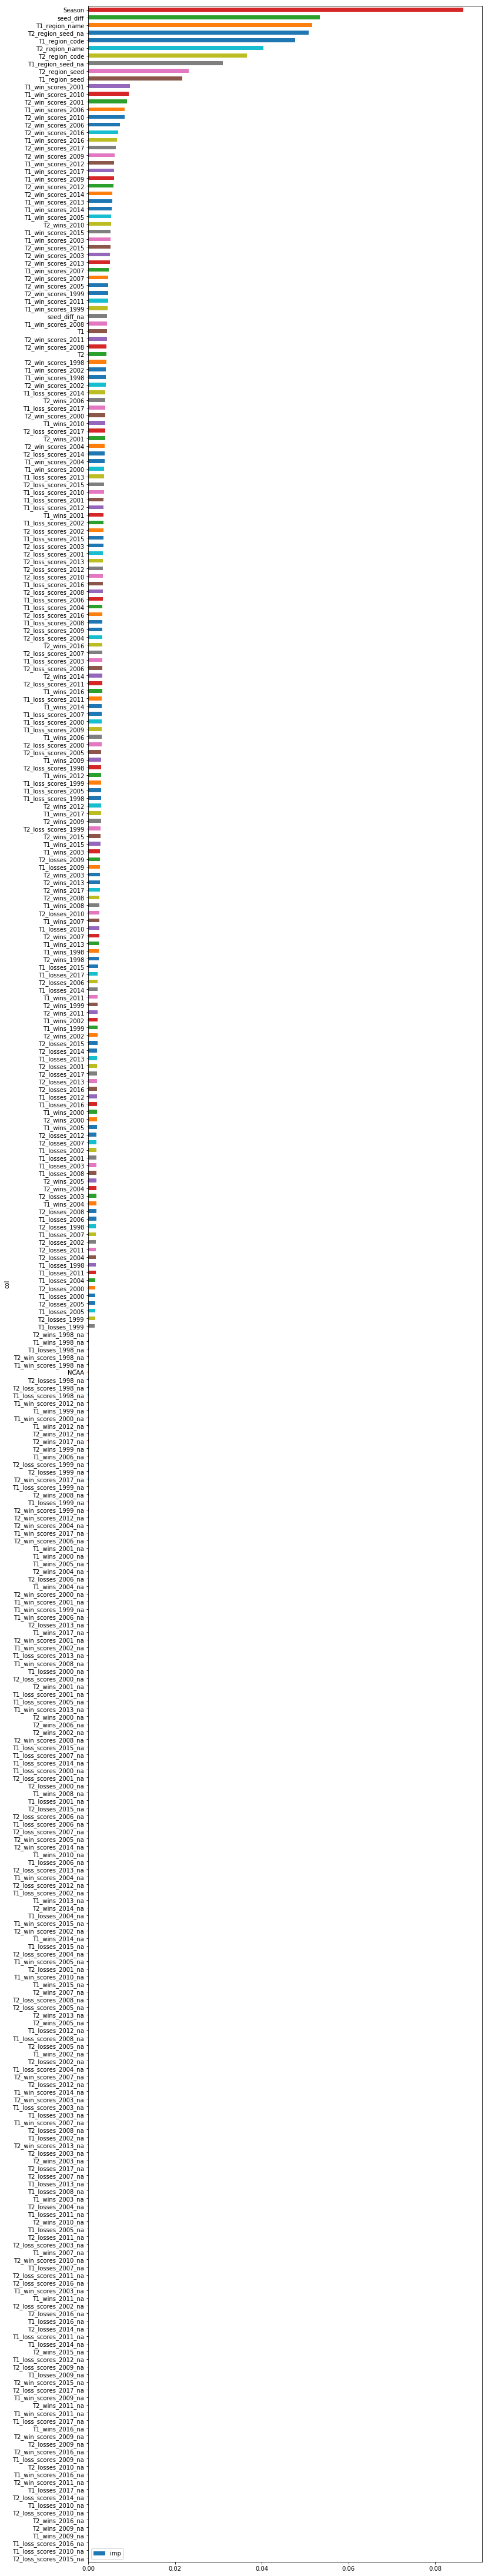

In [32]:
# Feature importance for the last season
pd.DataFrame({'col': x_train.columns, 'imp': m.feature_importances_}).sort_values('imp').plot(
    'col', 'imp', 'barh', figsize=(12,80));

# Submission file

ID - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.
Pred - this contains the predicted winning percentage for the first team identified in the ID field


In [60]:
df_submission = pd.read_feather('data/df_submission')

In [61]:
x_sub, _, _ = proc_df(df_submission, 'Pred', na_dict=nas)

In [65]:
submission = []
for season in models:
    x_t = x_sub[x_sub.Season == season].copy()
    x_t['Pred'] = get_pred(models[season], x_t)
    x_t['ID'] = x_t.apply(lambda x: f'{x.Season}_{x.T1}_{x.T2}', axis=1)
    submission.append(x_t[['ID', 'Pred']])

submission = pd.concat(submission)

In [63]:
submission.to_csv('2_result.csv', index=False)

In [64]:
pd.read_csv('2_result.csv').head()

,ID,Pred
0,2014_3103_3107,0.394202
1,2014_3103_3113,0.377298
2,2014_3103_3119,0.358279
3,2014_3103_3124,0.387701
4,2014_3103_3140,0.359831


In [66]:
from IPython.display import FileLink
FileLink('2_result.csv')

/home/rhermoza/github/kaggle/kaggle-basket/woman/2_result.csv

# ---